In [ ]:
1. Problem Description

2. Datasets Preview

3. Feature Selection

oil price: diff matters
transactions: mean matters 

In [5]:
# -------------- #

import pandas as pd
import os
import datetime
import math
import load_data
from tqdm import tqdm
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

import subprocess
from subprocess import check_output
import gc

from config import (
    RAW_DATA_DIR,
    LAG_DICT,
    SLIDING_DICT
)

%matplotlib inline

* stores.csv: Details about the stores, such as location and type.

* items.csv: Item metadata, such as class and whether they are perishable. Note, that perishable items have a higher scoring weight than others.

* transactions.csv: Count of sales transactions for the training data

* oil.csv: Daily oil price. This is relevant, because “Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.” (source)

* holidays_events.csv: Holidays in Ecuador. Some holidays can be transferred to another day (possibly from weekend to weekday).

In addition, the data description notes the importance of public sector pay days (on the 15th and the end of the month) as well as the impact of a major earthquake on April 16 2016.

## Load Data

In [6]:
holidays_events_df = pd.read_csv(RAW_DATA_DIR+'holidays_events.csv')
items_df = pd.read_csv(RAW_DATA_DIR+'items.csv')
oil_df = pd.read_csv(RAW_DATA_DIR+'oil.csv',parse_dates=['date'])
stores_df = pd.read_csv(RAW_DATA_DIR+'stores.csv')
transactions_df = pd.read_csv(RAW_DATA_DIR+'transactions.csv')

df = pd.read_csv(
    'datasets/train.csv', usecols=[1, 2, 3, 4, 5],
    parse_dates=["date"]
)

test_df = pd.read_csv(
    'datasets/test.csv', usecols=[1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]
)

/Users/liuyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Memory Deducion

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 5 columns):
date           datetime64[ns]
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.7+ GB


In [4]:
#--- for integer type columns ---
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['int']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)
    return df
#--- for float type columns ---
def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)            
    return df

In [5]:
df = change_datatype(df)
df = change_datatype_float(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 5 columns):
date           datetime64[ns]
store_nbr      int8
item_nbr       int32
unit_sales     float32
onpromotion    object
dtypes: datetime64[ns](1), float32(1), int32(1), int8(1), object(1)
memory usage: 2.9+ GB


#### Reduce from 4.7GB to 2.9GB

## train.csv

In [24]:
df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-01,25,103665,7.0,NaN
1,2013-01-01,25,105574,1.0,NaN
2,2013-01-01,25,105575,2.0,NaN
3,2013-01-01,25,108079,1.0,NaN
4,2013-01-01,25,108701,1.0,NaN


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 5 columns):
date           datetime64[ns]
store_nbr      int8
item_nbr       int32
unit_sales     float32
onpromotion    object
dtypes: datetime64[ns](1), float32(1), int32(1), int8(1), object(1)
memory usage: 2.9+ GB


In [66]:
t = df.copy()

In [67]:
t['onpromotion'] = t.onpromotion.fillna('NaN')

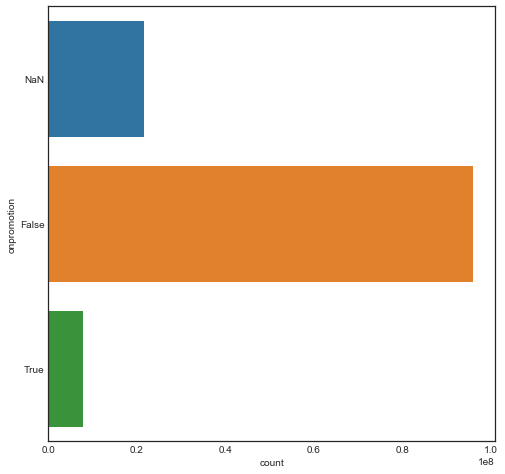

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=t['onpromotion'], data=t) 

In [69]:
del t

We need to fill these missing onpromotion info somehow.

In [16]:
print('Training date range is from {} to {}.'.format(df['date'].min().date(), df['date'].max().date()))
print('We have {} stores with {} item in training data'.format(df.store_nbr.unique().shape[0],df.item_nbr.unique().shape[0]))

Training date range is from 2013-01-01 to 2017-08-15.
We have 54 stores with 4036 item in training data


#### The following graph shows the number of selling items for each store. They are all from 2500 to 3000 items.

[Text(0, 0.5, 'Number of Selling Items'), Text(0.5, 0, 'Store Number')]

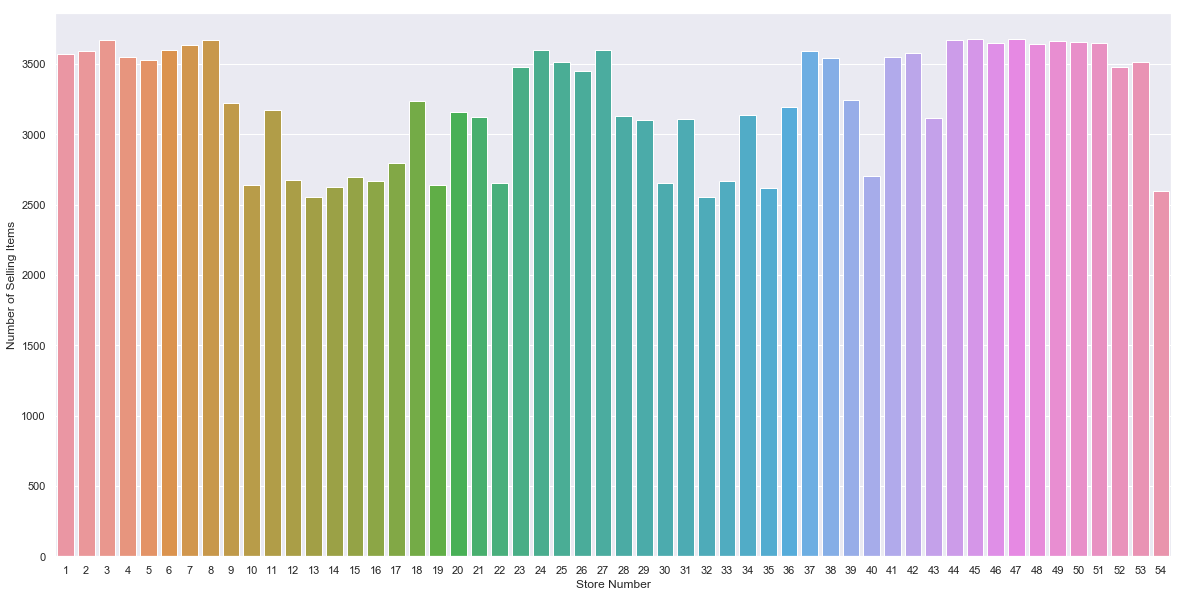

In [65]:
item_count_per_store = df[['store_nbr', 'item_nbr']].groupby('store_nbr').item_nbr.nunique().reset_index(level=0)
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x = 'store_nbr', y='item_nbr', data = item_count_per_store).set(xlabel='Store Number', ylabel='Number of Selling Items')

#### Top 10 sales stores

[Text(0, 0.5, 'No Of Sales'),
 Text(0.5, 0, 'Store Number'),
 Text(0.5, 1.0, 'TOP 10 Sales Store')]

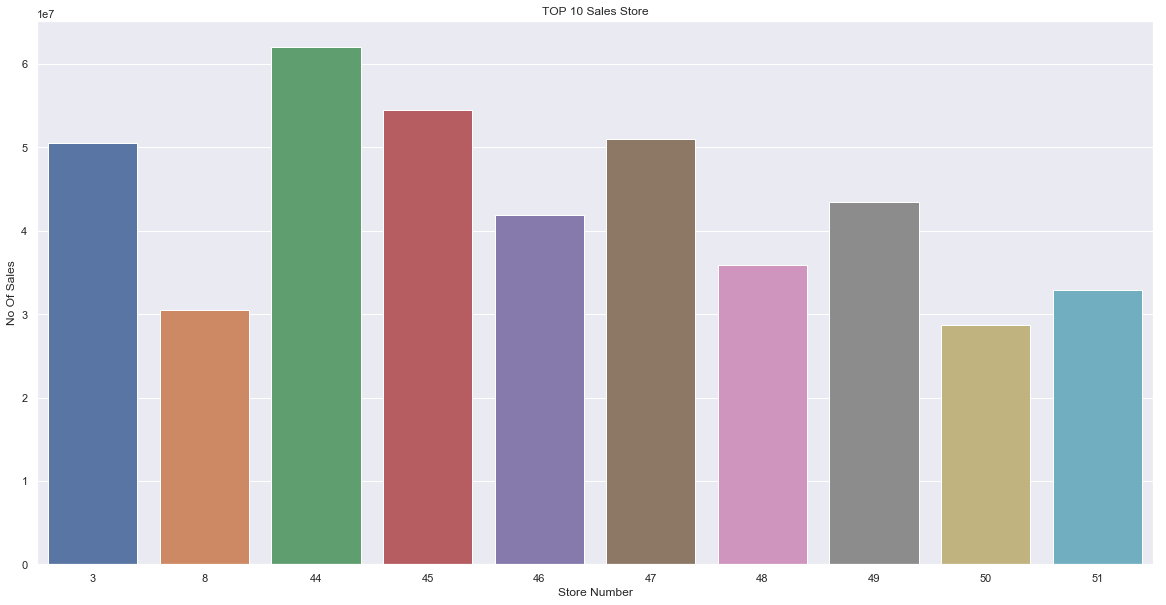

In [71]:
no_of_sales = df[['store_nbr', 'unit_sales']].groupby('store_nbr')['unit_sales'].sum().reset_index(level=0)
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x = 'store_nbr', y='unit_sales', data = no_of_sales.nlargest(10, columns = 'unit_sales')).set(title='TOP 10 Sales Store', xlabel='Store Number', ylabel='No Of Sales')

#### Top 10 sales items

[Text(0, 0.5, 'No Of Sales'),
 Text(0.5, 0, 'Item Number'),
 Text(0.5, 1.0, 'TOP 10 Sales Items')]

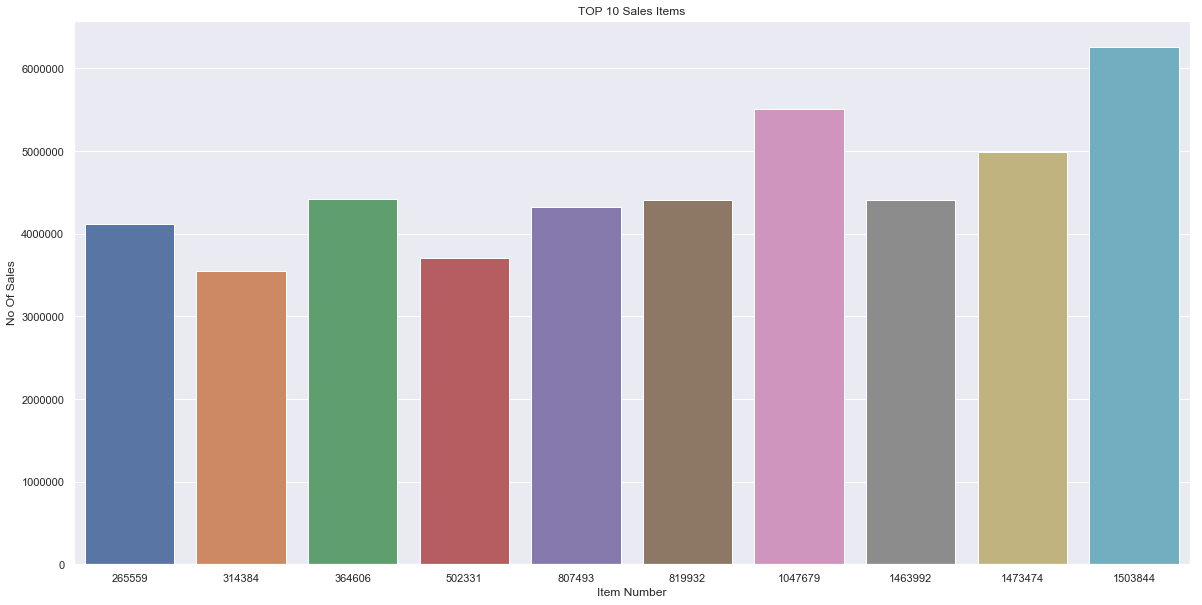

In [73]:
no_of_sales = df[['item_nbr', 'unit_sales']].groupby('item_nbr')['unit_sales'].sum().reset_index(level=0)
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x = 'item_nbr', y='unit_sales', data = no_of_sales.nlargest(10, columns = 'unit_sales')).set(title='TOP 10 Sales Items', xlabel='Item Number', ylabel='No Of Sales')

### A brief look at the best sell item in the best sell store.

In [87]:
tmp = df[df['store_nbr']==44]
item_nbr = tmp[['item_nbr', 'unit_sales']].groupby('item_nbr')['unit_sales'].sum().nlargest(1).index[0]
tmp = tmp[tmp['item_nbr']==item_nbr]

#### Compare the sales growth between 2013 and 2017

We can know that, for this item in this store sales in 2017 is quite different from other years.

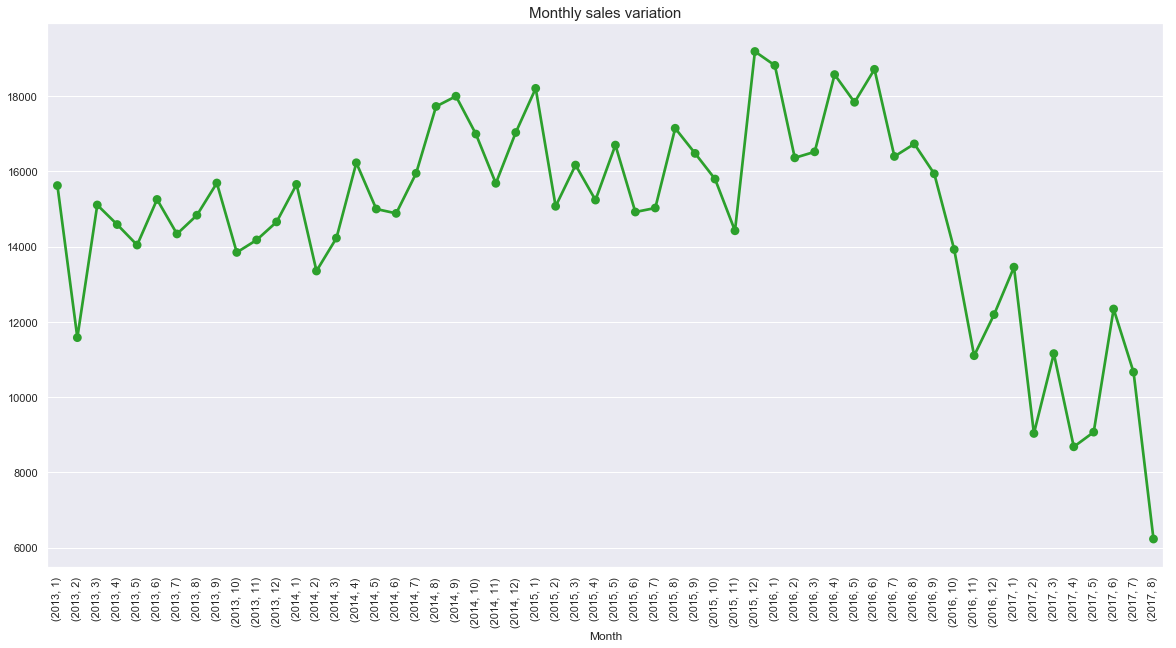

In [143]:
plt.figure(figsize=(20,10))
plt.xlabel('Month', fontsize=12)
plt.title('Monthly sales variation', fontsize=15)
plt.xticks(rotation='vertical')
smooth=tmp.copy()
smooth['Year'] = tmp.date.dt.year
smooth['Month'] = tmp.date.dt.month
smooth=smooth.groupby(['Year','Month'])['unit_sales'].sum()
sns.pointplot(smooth.index,smooth.values, alpha=0.8, color=color[2],)

2017 Sales

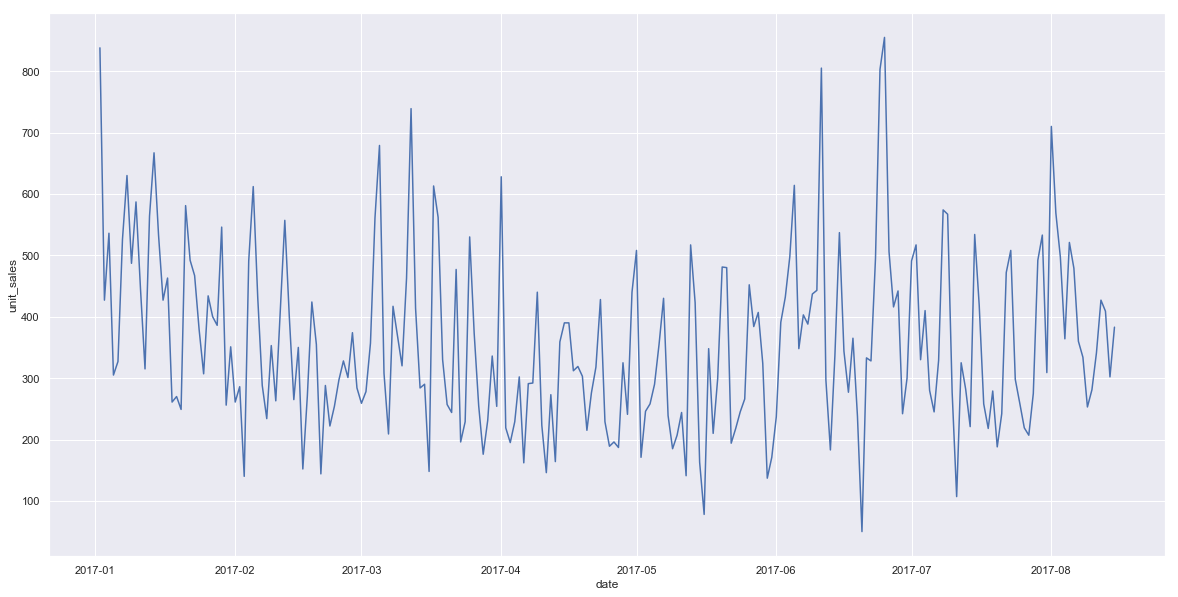

In [92]:
ax = sns.lineplot(x="date", y="unit_sales", data=tmp[tmp['date'].dt.year == 2017][['date', 'unit_sales']])

## Sales Return Graph

Sometime in time series modelling, it would be easier if we predict time series data return instead of the number.

That's because, for some time series the return are more stable and more stationary.  

In [74]:
#TODO To be continued in the future.

## test.csv

In [144]:
test_df.head()

,date,store_nbr,item_nbr,onpromotion
0,2017-08-16,1,96995,False
1,2017-08-16,1,99197,False
2,2017-08-16,1,103501,False
3,2017-08-16,1,103520,False
4,2017-08-16,1,103665,False


In [7]:
items_df.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [9]:
print('Test date range is from {} to {}.'.format(test_df['date'].min().date(), test_df['date'].max().date()))
print('We have {} stores with {} item in test data'.format(test_df.store_nbr.unique().shape[0],test_df.item_nbr.unique().shape[0]))
nbr_missing=len(set(test_df.item_nbr.unique()) - set(df.item_nbr.unique()))
print('There are {} items appearing in the test data but not in the train sets'.format(nbr_missing))
print('For these {} items, we will set the predicted values to 0'.format(nbr_missing))
print('Another solution for this 60 items is to use items\' family, class and perishable to generate more accurate results. Considering time, I will not build this model')

Test date range is from 2017-08-16 to 2017-08-31.
We have 54 stores with 3901 item in test data
There are 60 items appearing in the test data but not in the train sets
For these 60 items, we will set the predicted values to 0
Another solution for this 60 items is to use items' family, class and perishable       to generate more accurate results. Considering time, I will not build this model


### IMPORTANT

In test.csv, it tries to ask us to predict new items. 60/3901 (1.5%) are new items. 


## store.csv

In [21]:
print('In the datasets, we have {} stores in total'.format(stores_df.shape[0]))
print('They are from {} different cities and {} states. Also, they can be classified into {} types and {} clusters'.format(
    stores_df.city.unique().shape[0],
    stores_df.state.unique().shape[0],
    stores_df.type.unique().shape[0],
    stores_df.cluster.unique().shape[0]
))

In the datasets, we have 54 stores in total


In [153]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


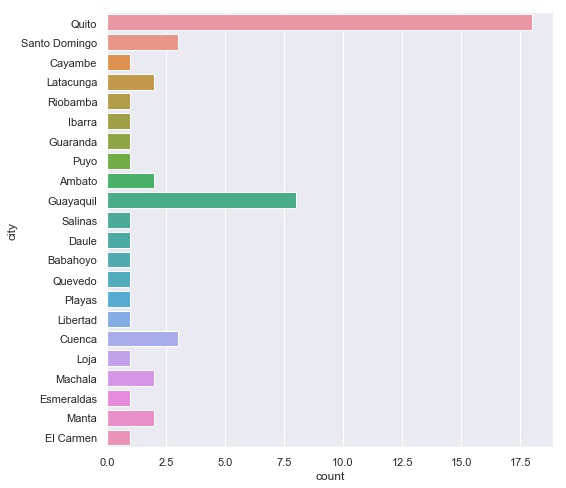

In [157]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=stores_df['city'], data=stores_df) 

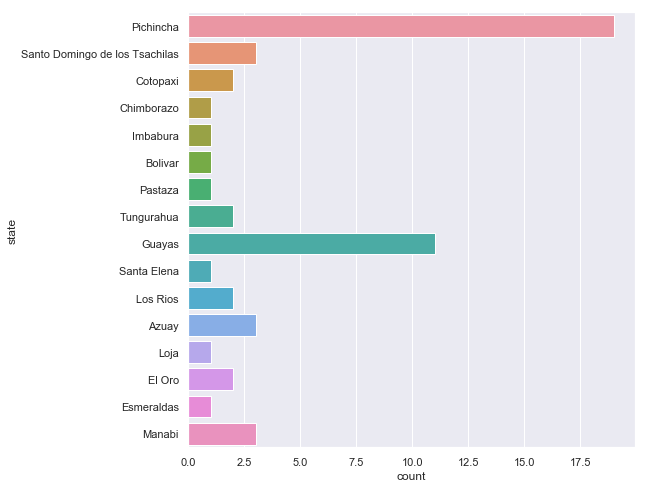

In [159]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=stores_df['state'], data=stores_df) 

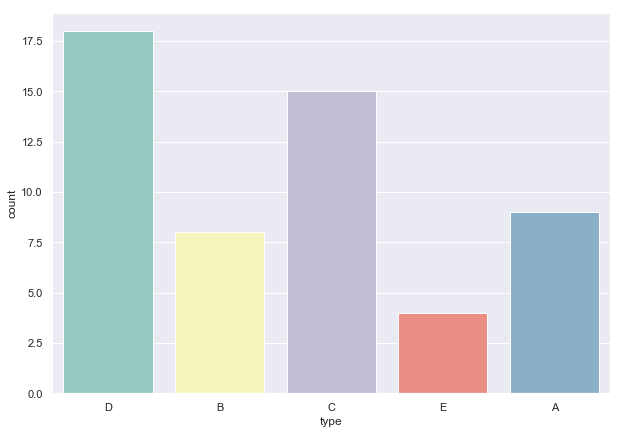

In [161]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax = sns.countplot(x="type", data=stores_df, palette="Set3")

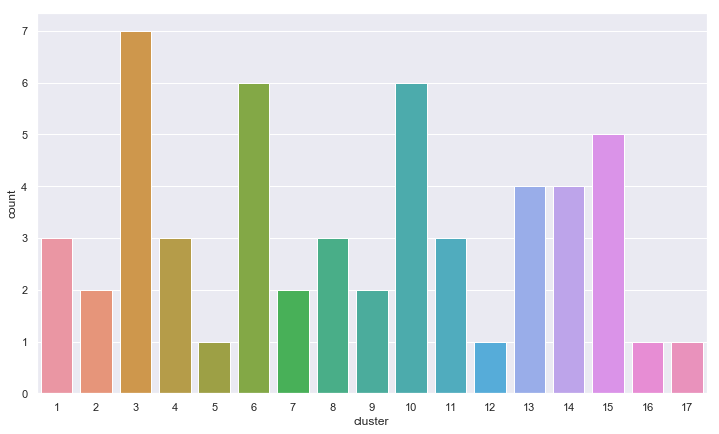

In [166]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax = sns.countplot(x="cluster", data=stores_df)

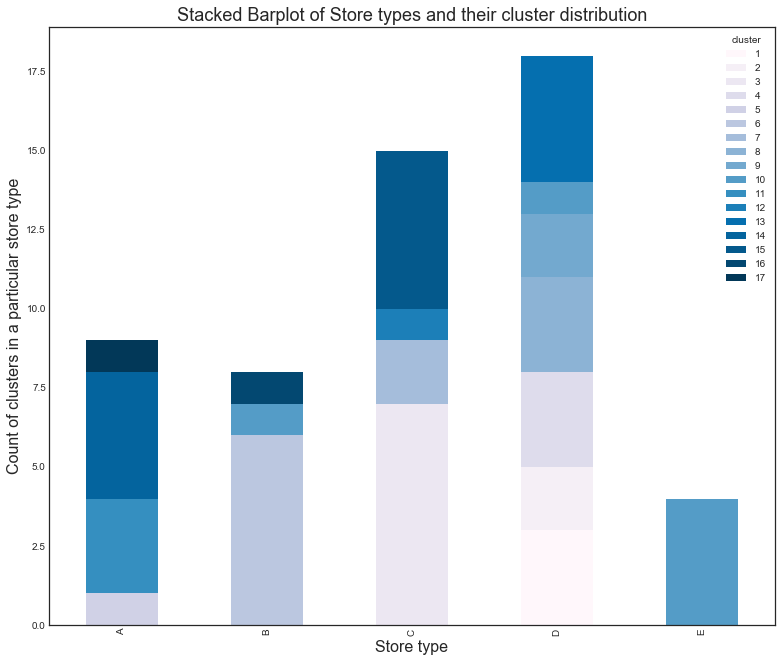

In [17]:
plt.style.use('seaborn-white')
#plt.style.use('dark_background')
type_cluster = stores_df.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()

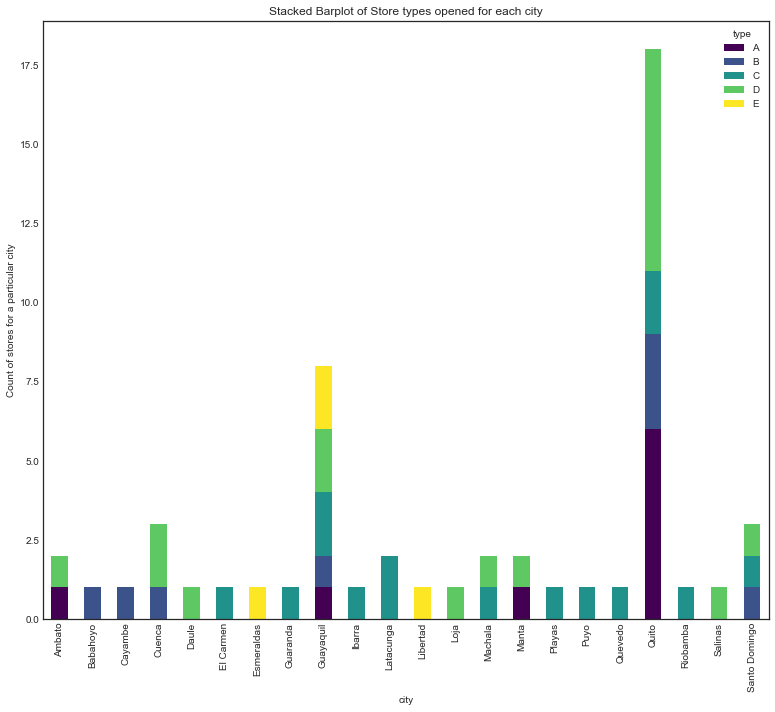

In [18]:
# plt.style.use('dark_background')
plt.style.use('seaborn-white')
city_cluster = stores_df.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

## items.csv

In [15]:
items_df.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


NOTICE: Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0



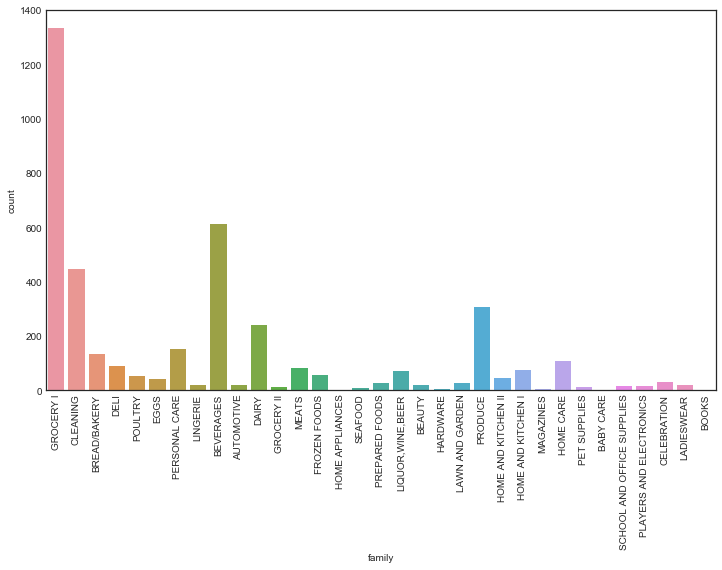

In [32]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = sns.countplot(x="family", data=items_df)

There are 337 classes in total


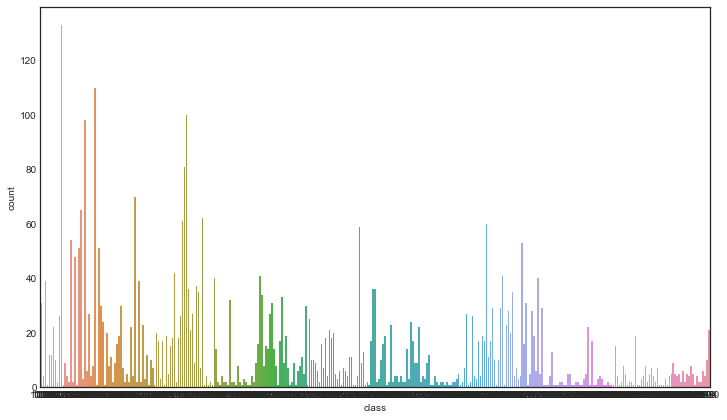

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax = sns.countplot(x="class", data=items_df)
print('There are {} classes in total'.format(items_df['class'].unique().shape[0]))

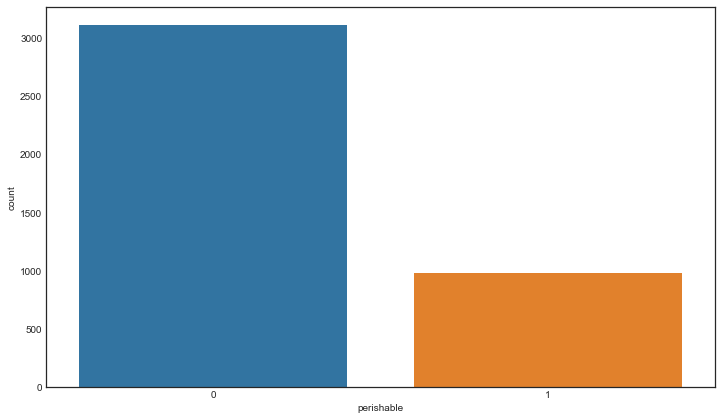

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax = sns.countplot(x="perishable", data=items_df)

## oil.csv

In [58]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


/Users/liuyu/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


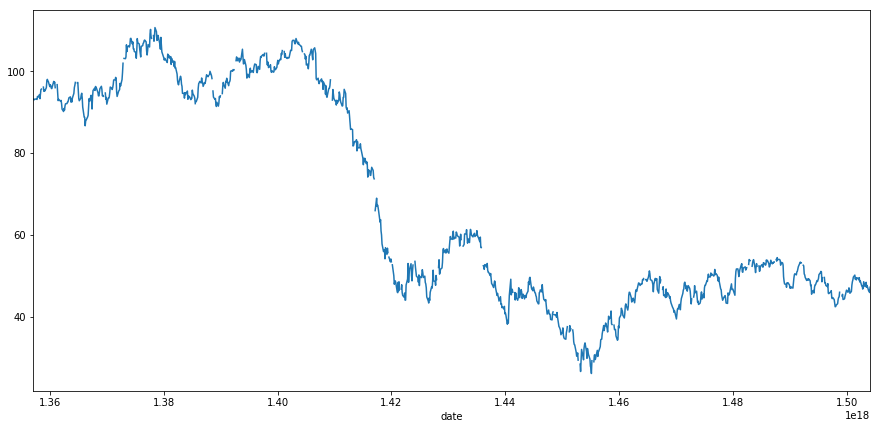

In [4]:
f, ax = plt.subplots(figsize=(15, 7))
sns.tsplot(data = oil_df['dcoilwtico'], time = oil_df['date'],ci="sd")

## holidays_events.csv 

In [7]:
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


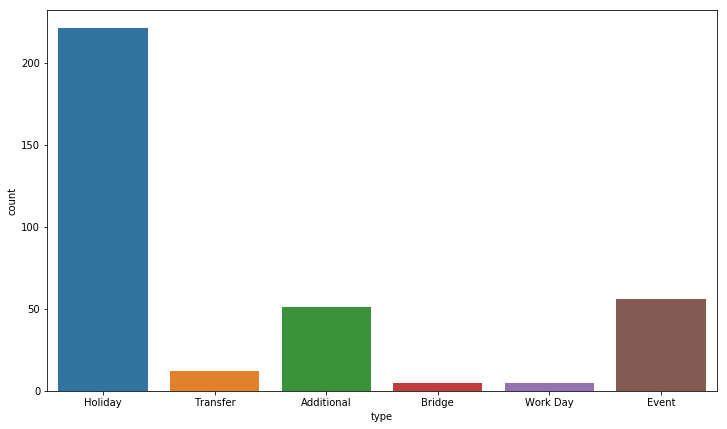

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax = sns.countplot(x="type", data=holidays_events_df)

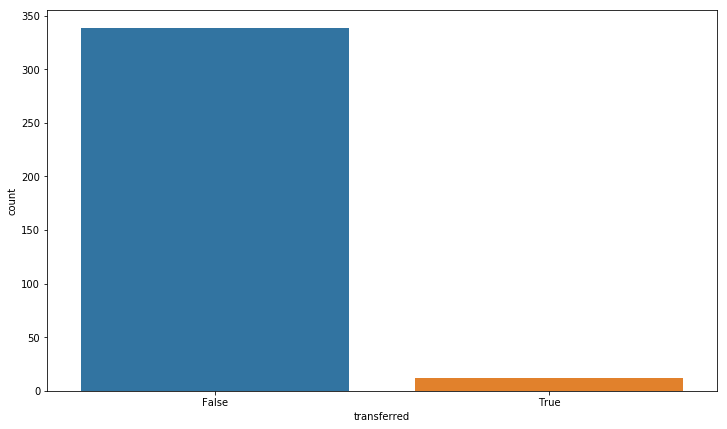

In [13]:
plt.figure(figsize=(20,10))
plt.xlabel('Month', fontsize=12)
plt.title('Monthly sales variation', fontsize=15)
plt.xticks(rotation='vertical')
smooth=tmp.copy()
smooth['Year'] = tmp.date.dt.year
smooth['Month'] = tmp.date.dt.month
smooth=smooth.groupby(['Year','Month'])['unit_sales'].sum()
sns.pointplot(smooth.index,smooth.values, alpha=0.8, color=color[2],)

In [27]:
from datetime import date, timedelta

test_start = date(2017, 8, 16)
test_end = date(2017,8, 31)

holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
holidays_events_df[holidays_events_df['date'].between(test_start, test_end)]

,date,type,locale,locale_name,description,transferred
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


In [30]:
holidays_events_df[holidays_events_df['description'] == 'Fundacion de Ambato']

,date,type,locale,locale_name,description,transferred
16,2012-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
69,2013-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
132,2014-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
187,2015-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
271,2016-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


#### In the test period, there's only one special event on 24 Aug 2017. So we only need to generate a feature for this special event.

## transactions.csv

In [32]:
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


#### Take store_nbr 25 as an example

In [60]:
tmp = transactions_df[transactions_df['store_nbr']==25]

### Transaction

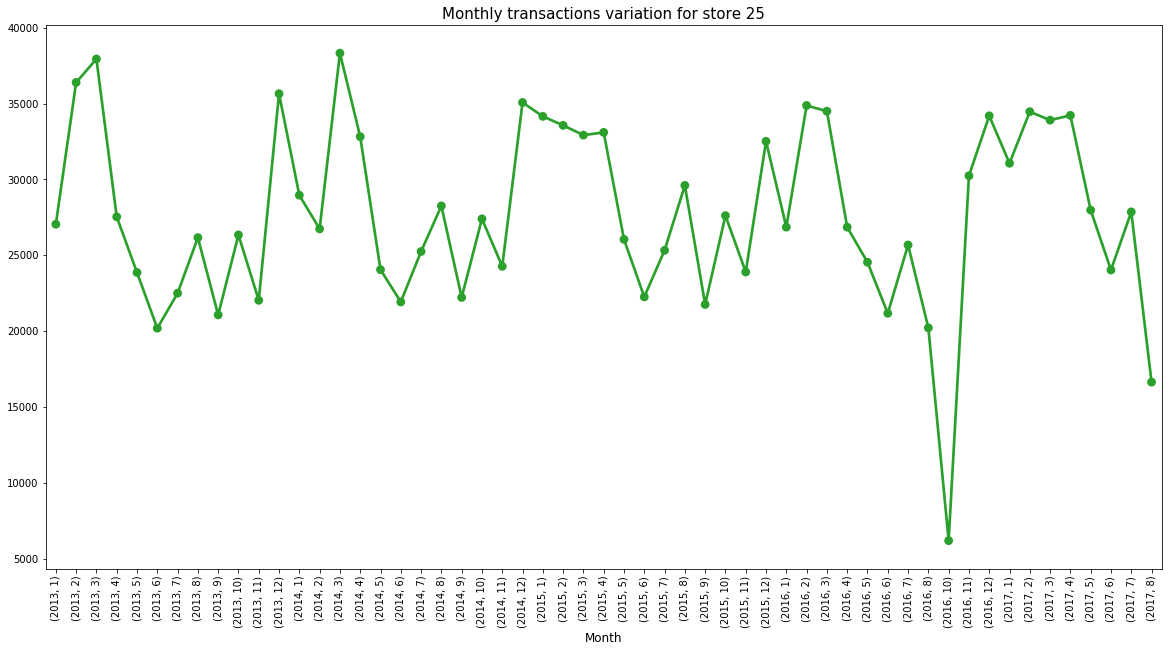

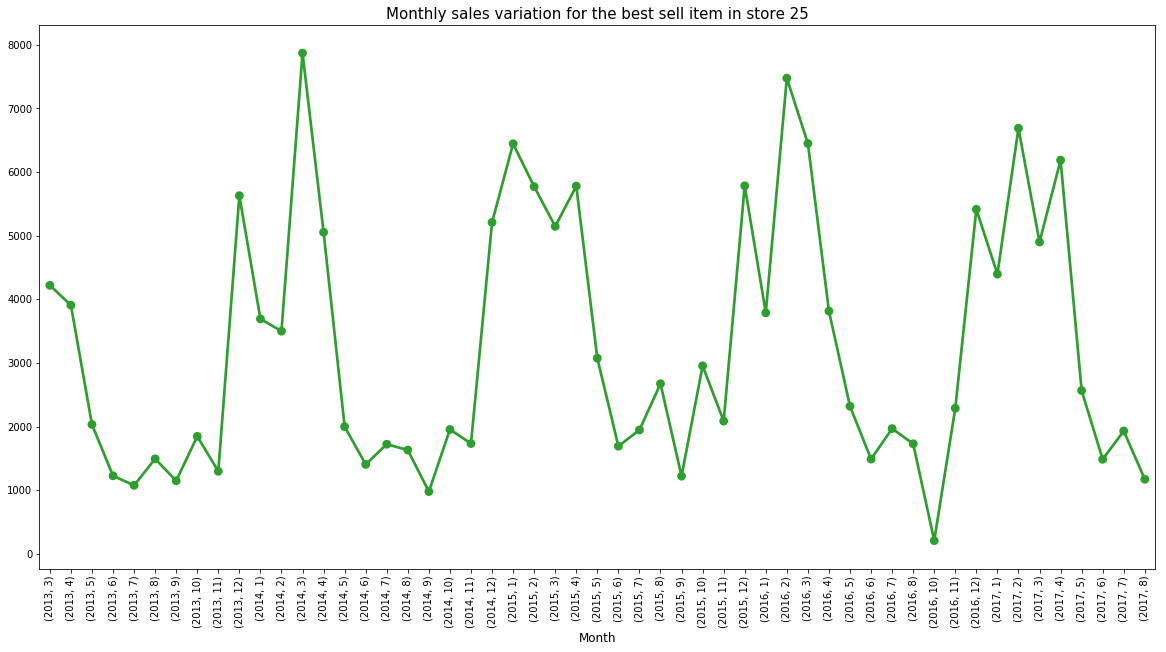

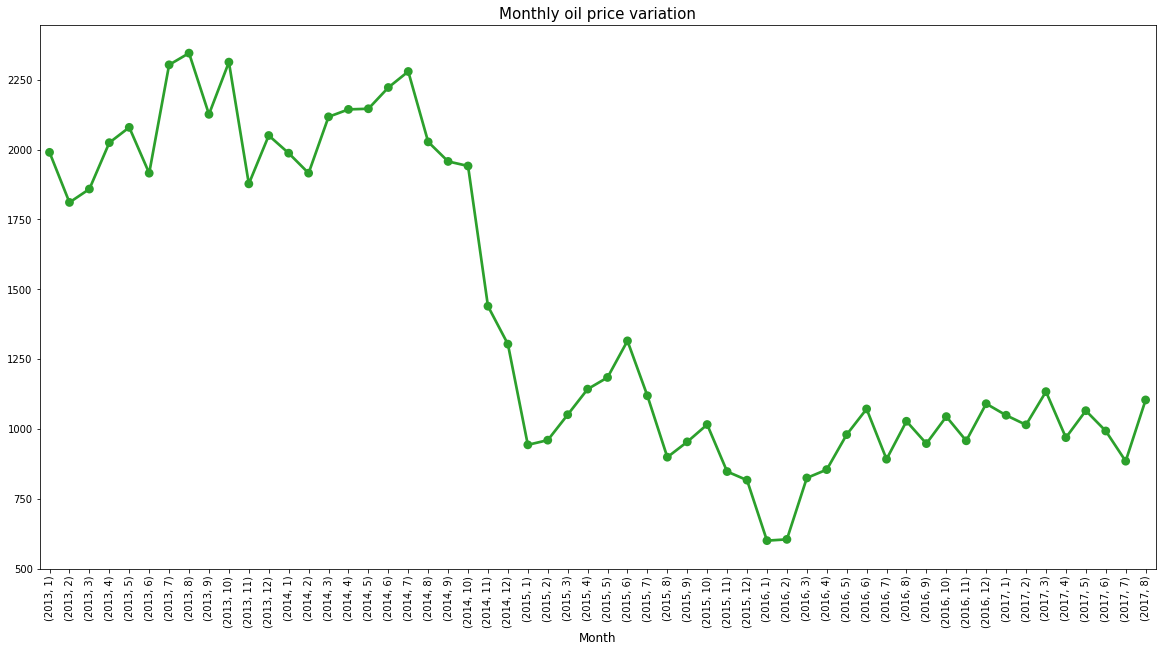

In [71]:
plt.figure(figsize=(20,10))
plt.xlabel('Month', fontsize=12)
plt.title('Monthly transactions variation for store 25', fontsize=15)
plt.xticks(rotation='vertical')
tmp = transactions_df[transactions_df['store_nbr']==25]
tmp.date = pd.to_datetime(tmp.date)
smooth=tmp.copy()
smooth['Year'] = tmp.date.dt.year
smooth['Month'] = tmp.date.dt.month
smooth=smooth.groupby(['Year','Month'])['transactions'].sum()
sns.pointplot(smooth.index,smooth.values, alpha=0.8, color=color[2],)

plt.figure(figsize=(20,10))
plt.xlabel('Month', fontsize=12)
plt.title('Monthly sales variation for the best sell item in store 25', fontsize=15)
plt.xticks(rotation='vertical')
tmp = df[df['store_nbr']==25]
item_nbr = tmp[['item_nbr', 'unit_sales']].groupby('item_nbr')['unit_sales'].sum().nlargest(1).index[0]
tmp = tmp[tmp['item_nbr']==item_nbr]
smooth=tmp.copy()
smooth['Year'] = tmp.date.dt.year
smooth['Month'] = tmp.date.dt.month
smooth=smooth.groupby(['Year','Month'])['unit_sales'].sum()
sns.pointplot(smooth.index,smooth.values, alpha=0.8, color=color[2],)


plt.figure(figsize=(20,10))
plt.xlabel('Month', fontsize=12)
plt.title('Monthly oil price variation', fontsize=15)
plt.xticks(rotation='vertical')
tmp = oil_df.copy()
smooth=tmp.copy()
smooth['Year'] = tmp.date.dt.year
smooth['Month'] = tmp.date.dt.month
smooth=smooth.groupby(['Year','Month'])['dcoilwtico'].sum()
sns.pointplot(smooth.index,smooth.values, alpha=0.8, color=color[2],)

del smooth, tmp

### We can see taht sales total's growth is very similar with transactions'. However for this perticular store and particular item, oil price growth seems irrelevant.

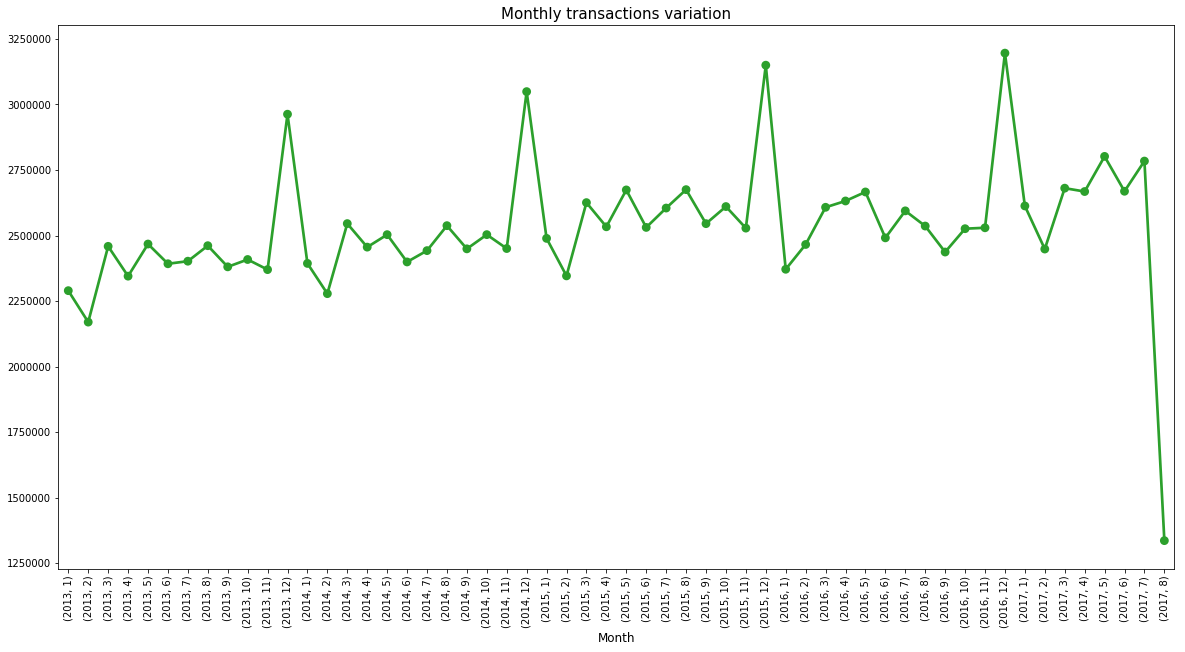

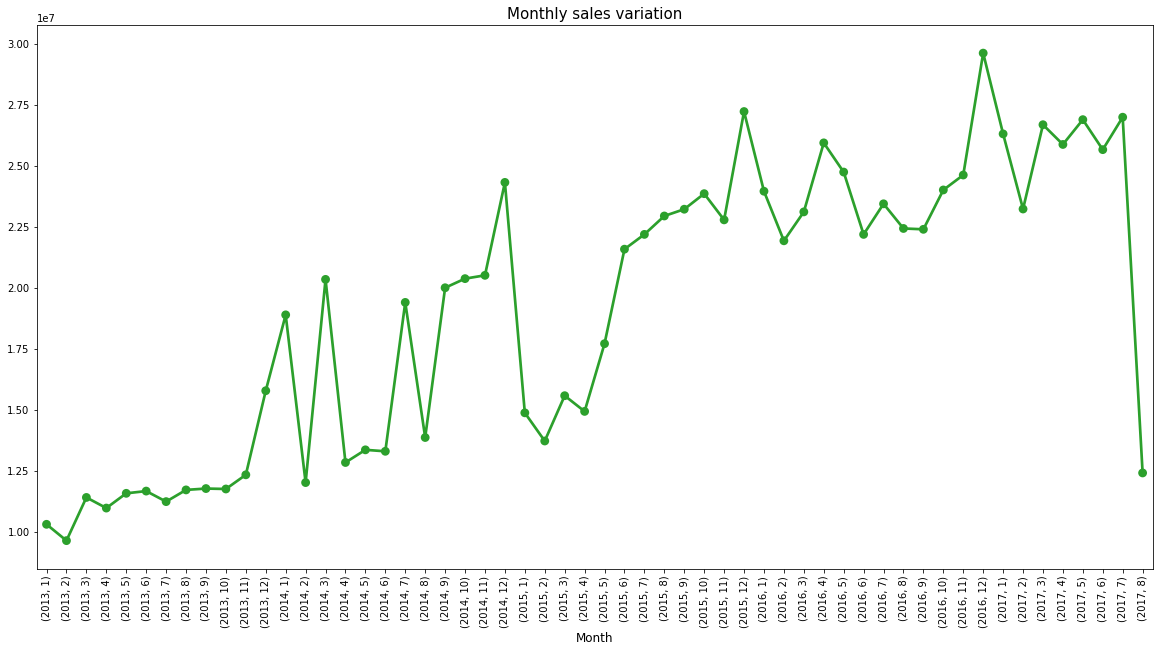

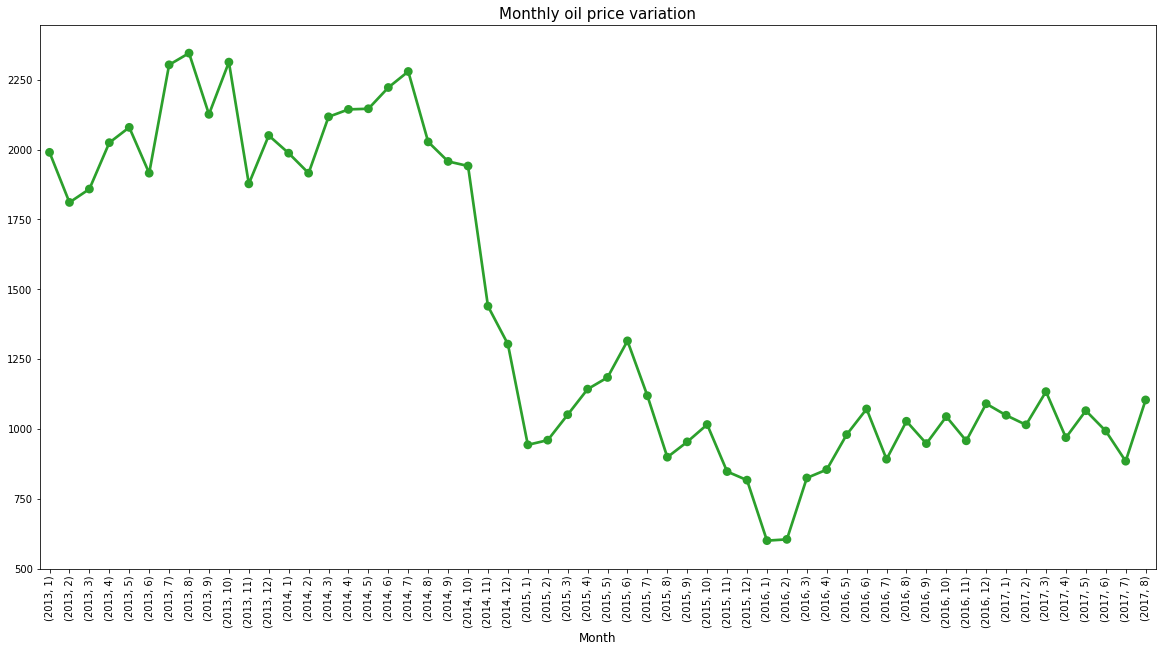

In [72]:
plt.figure(figsize=(20,10))
plt.xlabel('Month', fontsize=12)
plt.title('Monthly transactions variation', fontsize=15)
plt.xticks(rotation='vertical')
# tmp = transactions_df[transactions_df['store_nbr']==25]

tmp = transactions_df.copy()
tmp.date = pd.to_datetime(tmp.date)
smooth=tmp.copy()
smooth['Year'] = tmp.date.dt.year
smooth['Month'] = tmp.date.dt.month
smooth=smooth.groupby(['Year','Month'])['transactions'].sum()
sns.pointplot(smooth.index,smooth.values, alpha=0.8, color=color[2],)

plt.figure(figsize=(20,10))
plt.xlabel('Month', fontsize=12)
plt.title('Monthly sales variation', fontsize=15)
plt.xticks(rotation='vertical')

tmp = df.copy()
smooth=tmp.copy()
smooth['Year'] = tmp.date.dt.year
smooth['Month'] = tmp.date.dt.month
smooth=smooth.groupby(['Year','Month'])['unit_sales'].sum()
sns.pointplot(smooth.index,smooth.values, alpha=0.8, color=color[2],)


plt.figure(figsize=(20,10))
plt.xlabel('Month', fontsize=12)
plt.title('Monthly oil price variation', fontsize=15)
plt.xticks(rotation='vertical')
tmp = oil_df.copy()
smooth=tmp.copy()
smooth['Year'] = tmp.date.dt.year
smooth['Month'] = tmp.date.dt.month
smooth=smooth.groupby(['Year','Month'])['dcoilwtico'].sum()
sns.pointplot(smooth.index,smooth.values, alpha=0.8, color=color[2],)

del smooth, tmp

### As we can see, from 2013 to 2017, the number of monthly transactions has gr

### Draw transactions for store_nbr 25 between 2015 and 2017

In [ ]:
tmp = transactions_df[transactions_df['store_nbr']==25]

/Users/liuyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/liuyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


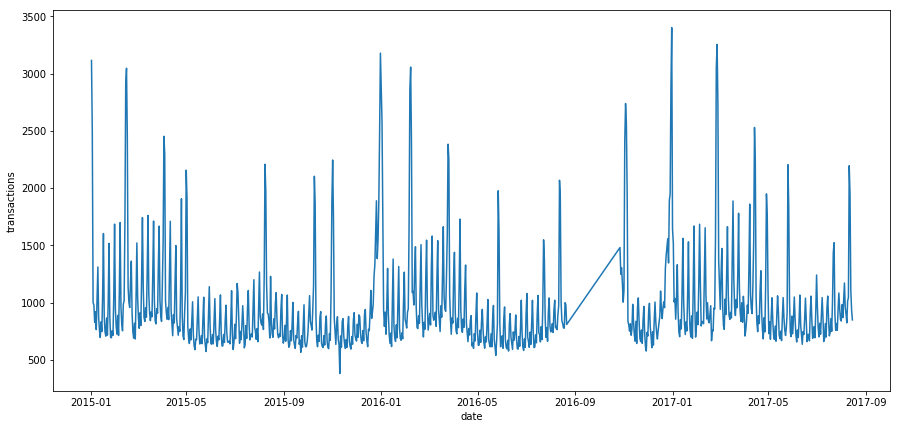

In [49]:
tmp_transactions['date'] = pd.to_datetime(tmp['date'])
tmp = tmp[tmp['date']>date(2015,1,1)]
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.lineplot(x="date", y="transactions", data=tmp)

## Step by step build the model

#### Time series data itself - unit sales